In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
pd.options.mode.chained_assignment = None  # default='warn'

from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
# import matplotlib.dates as mdates # Styling dates
# import mplfinance as mpf # Matplotlib finance
from datetime import timedelta

# Get the data
df_basic = pd.read_csv('./cleaned/basic.csv')
df_other = pd.read_csv('./cleaned/other.csv')
df_dividend = pd.read_csv('./cleaned/dividend.csv')

In [ ]:
# Format date fields
df_basic['Date'] = pd.to_datetime(df_basic['Date'])
df_other['Date'] = pd.to_datetime(df_other['Date'])
df_dividend['Date'] = pd.to_datetime(df_dividend['Date'])

In [ ]:
# Account for stock splits

tickers_all = df_basic['Name'].unique()
allSplits = []

for ticker in tickers_all:

    # Get the split and convert to a df
    splits = yf.Ticker(ticker).splits

    df_split = []

    # If there was a split, append the df to allSplits. The ignoring of PFE is a quirk with a spin off they did with Viatris in 2020. This is a bad fix but it'll do for now
    if len(splits) != 0 and ticker != "PFE" and ticker != "INRG.L":
        df_split = pd.DataFrame({'Date':splits.index, 'Split':splits.values})
        df_split["Name"] = ticker
        allSplits.append(df_split)

allSplits = pd.concat(allSplits)

# Iterate through splits and alter share counts as necessary
for index, row in allSplits.iterrows():
    df_basic.loc[(df_basic["Name"] == row["Name"]) & (df_basic["Date"] < row["Date"]), ["ShareCount"]] = (df_basic['ShareCount'] * row["Split"]).round(6)

In [ ]:
# Get a valid pandas date
def getDateFormat(day, month, year):
    return pd.to_datetime(f"{year}-{month}-{day}")

In [ ]:
# Get the shares held on a given day
def getDayPortfolio(day = pd.to_datetime("today")):

    # Get the buys and sells for each day before the given date
    df_buysInRange = df_buys.loc[df_basic["Date"] <= day, ["Date", "Name", "ShareCount"]]
    df_sellsInRange = df_sells.loc[df_basic["Date"] <= day, ["Date", "Name", "ShareCount"]]

    # Any missing sells, i.e. any stock we've bought but not sold any of, need to still be in the resulting 'sell' df
    df_emptySells = df_buysInRange.copy()
    df_emptySells["ShareCount"] = 0
    df_sellsInRange = pd.concat([df_sellsInRange, df_emptySells])

    # Aggregate to get total shares in and out
    sharesIn = df_buysInRange.groupby('Name').agg({'ShareCount': 'sum'})['ShareCount'].reset_index()
    sharesOut = df_sellsInRange.groupby('Name').agg({'ShareCount': 'sum'})['ShareCount'].reset_index()

    # Format the aggregations
    sharesIn.rename(columns={"ShareCount": "SharesIn"}, inplace=True)
    sharesOut.rename(columns={"ShareCount": "SharesOut"}, inplace=True)
    sharesOut.drop(columns="Name", inplace=True)

    # Calculate net shares
    sharesTotal = pd.concat([sharesIn, sharesOut], axis=1)
    sharesTotal["ShareCount"] = (sharesTotal["SharesIn"] - sharesTotal["SharesOut"]).round(5)

    # Format the portfolio
    portfolio = sharesTotal.loc[sharesTotal["ShareCount"] != 0]
    portfolio = portfolio.drop(columns=["SharesIn", "SharesOut"])

    return portfolio

In [ ]:
#Split buys and sells into separate dataframes
df_buys = df_basic.loc[df_basic["Type"] == "BUY"]
df_sells = df_basic.loc[df_basic["Type"] == "SELL"]

# A list of currently held tickers
tickers_current = getDayPortfolio()["Name"].explode().unique() 

# A list of all tickers with their currency
tickers_currency = df_buys[["Name", "Currency"]].drop_duplicates().reset_index(drop=True)

In [ ]:
# Get any necessary exchange rates
df_exchange_USDGBP = web.DataReader("GBPUSD=X", 'yahoo', df_buys["Date"].min(), pd.to_datetime("today"))
df_exchange_USDGBP.drop(columns=["High", "Low", "Open", "Volume", "Adj Close"], inplace=True)
df_exchange_USDGBP = df_exchange_USDGBP.reset_index()

# Get the first and last date
currentDate_fx = df_exchange_USDGBP["Date"].min()
lastDate_fx = pd.to_datetime("today")
lastDate_fx = lastDate_fx.replace(hour=0, minute=0, second=0, microsecond=0)

# Iterate through each day
while currentDate_fx != lastDate_fx:
    dayCounter_fx = 1

    # If the current day doesn't have an exchnage rate entry
    while len(df_exchange_USDGBP.loc[df_exchange_USDGBP["Date"] == currentDate_fx]) == 0:

        # Get the previous days entry
        prevDate_fx = currentDate_fx - timedelta(days=dayCounter_fx)
        df_previousFx = df_exchange_USDGBP.loc[df_exchange_USDGBP["Date"] == prevDate_fx]
        df_previousFx["Date"] = currentDate_fx

        # Add this entry to the exchange rate df
        df_exchange_USDGBP = df_exchange_USDGBP.append(df_previousFx, ignore_index=True)
        dayCounter_fx = dayCounter_fx + 1

    currentDate_fx = currentDate_fx + timedelta(days=1)

# Rename the Close column to avoid confusion in the next cell...
df_exchange_USDGBP = df_exchange_USDGBP.rename(columns={"Close": "Rate"})


In [ ]:
# Import all closing prices for each ticker for the required date ranges
df_closing_all = []

for ticker in tickers_all:

    df_closing_ticker = []

    # Get the first transaction date for the ticker
    date_first = pd.to_datetime("today")
    date_first = df_buys.loc[df_buys["Name"] == ticker]["Date"].min()

    # Get the last transaction date for the ticker, or the current date if it's still being held
    date_last = pd.to_datetime("today")
    if ticker not in tickers_current:
        date_last = df_sells.loc[df_sells["Name"] == ticker]["Date"].max()
    # Get the close prices for each day
    # Yahoo has missing data for INRG. This isn't ideal but it's the best way to fix it - will need to manually download any mising data in future
    if ticker == "INRG.L":
        df_closing_ticker = pd.read_csv('./inputs/inrg.csv')
        df_closing_ticker["Date"] = pd.to_datetime(df_closing_ticker["Date"])
    else:
        df_closing_ticker = web.DataReader(ticker, 'yahoo', date_first, date_last)    

    # Format the df
    df_closing_ticker.drop(columns=["High", "Low", "Open", "Volume", "Adj Close"], errors="ignore", inplace=True)
    df_closing_ticker["Name"] = ticker

    # Get the currency for the current ticker
    tickerCurrency = tickers_currency.loc[tickers_currency["Name"] == ticker, "Currency"].values[0]

    # If it's USD, divide by the exchange rate for the relevant day
    if tickerCurrency == "USD":
        df_closing_ticker = pd.merge(df_closing_ticker, df_exchange_USDGBP, how="left", on="Date")
        df_closing_ticker["Close"] = df_closing_ticker["Close"]/df_closing_ticker["Rate"]
        df_closing_ticker.drop(columns=["Rate"], inplace=True)

    # If it's GBp, divide by 100 to convert to £
    elif tickerCurrency == "GBP":
        df_closing_ticker["Close"] = df_closing_ticker["Close"]/100
    else:
        print("ERROR: Unidentified Currency - ", ticker)
    
    df_closing_all.append(df_closing_ticker.reset_index())

# Concatenate all data
df_closing_all = pd.concat(df_closing_all)
df_closing_all.drop(columns=["index"], inplace=True)

In [ ]:
# Get daily portfolio value
dates = []
values = []

currentDate = df_buys["Date"].min()

endDate = pd.to_datetime("today")
endDate = endDate.replace(hour=0, minute=0, second=0, microsecond=0)

# Move day-by-day from the first date to now
while currentDate != endDate:

    # Get the portoflio of holdings for this date
    df_portfolio = getDayPortfolio(currentDate)

    # Get the closing prices for this day
    df_relevantClosing = df_closing_all.loc[df_closing_all["Date"] == currentDate]

    # Get all tickers for this day
    tickers = df_portfolio["Name"].values.tolist()

    # Loop through the tickers that we havent managed to extract closing data from, and keep checking the previous day until we get a value
    for t in tickers:        
        dayCounter = 1
        while t not in df_relevantClosing.values:
            prevDay = currentDate - timedelta(days=dayCounter)
            df_previousClosing = df_closing_all.loc[(df_closing_all["Date"] == prevDay) & (df_closing_all["Name"] == t)]
            df_relevantClosing = df_relevantClosing.append(df_previousClosing, ignore_index=True)
            dayCounter = dayCounter + 1

    # Merge these together, and calculate the value of each stock    
    df_portfolio = pd.merge(df_portfolio, df_relevantClosing, on="Name")
    df_portfolio["Value"] = df_portfolio["ShareCount"] * df_portfolio["Close"]
    
    dates.append(currentDate)
    values.append(df_portfolio["Value"].sum())

    currentDate = currentDate + timedelta(days=1)
        
df_dailyValue = pd.DataFrame(list(zip(dates, values)),columns =['Date', 'Value'])
df_dailyValue = df_dailyValue[df_dailyValue["Value"] != 0]

In [ ]:
# TODO: FIX!!
df_deposits = df_other.loc[df_other["Type"] == "Deposit", ["Date", "Value"]]
df_dailyGains = df_dailyValue.copy()
print(df_deposits)
for i_daily, row_daily in df_dailyValue.iterrows():
    for i_deposit, row_deposit in df_deposits.iterrows():
        if row_daily["Date"] == row_deposit["Date"]:
            value = df_dailyGains.loc[df_dailyGains["Date"] >= row_daily["Date"], "Value"]
            df_dailyGains.loc[df_dailyGains["Date"] >= row_daily["Date"], "Value"] = value - row_deposit["Value"]

In [ ]:
# Generate a daily summary table using the 'other' dataframe initially
df_dailyActivity = pd.pivot_table(
    df_other, 
    values="Value", 
    index="Date", 
    columns="Type", 
    aggfunc=np.sum).fillna(0)

# Convert buys and sells to same format as daily summary
df_basicPivot = pd.pivot_table(
    pd.concat([df_buys[["Date", "Type", "Value"]], df_sells[["Date", "Type", "Value"]]]), 
    values="Value", index="Date", 
    columns="Type", 
    aggfunc=np.sum
).fillna(0)

# pivot dividend table
df_diviPivot = pd.pivot_table(
    df_dividend, 
    values="Value", index="Date",  
    aggfunc=np.sum
).fillna(0)

# Concatenate daily summary with buys, sells, and dividends
df_dailyActivity = pd.concat([df_dailyActivity, df_basicPivot, df_diviPivot], axis=1).fillna(0)

# Format daily summary
df_dailyActivity = df_dailyActivity.rename(columns={"BUY": "Total Bought", "SELL": "Total Sold", "Value": "Dividend"})
df_dailyActivity['Net Income']= df_dailyActivity.sum(axis=1)
df_dailyActivity = df_dailyActivity.round(2)
df_dailyActivity = df_dailyActivity.reset_index()

In [123]:
def price_plot(graph, df = df_dailyValue, c = 'green', start = df_dailyValue["Date"].min(), end = df_dailyValue["Date"].max()):

    # Get the date range
    df_sub = df.loc[(df["Date"] >= start) & (df["Date"] <= end)]

    # Convert to Numpy array
    np_dailyValue = df_sub.to_numpy()
            
    # Define the plot line
    graph.plot(np_dailyValue[:,0], np_dailyValue[:,1], color=c)


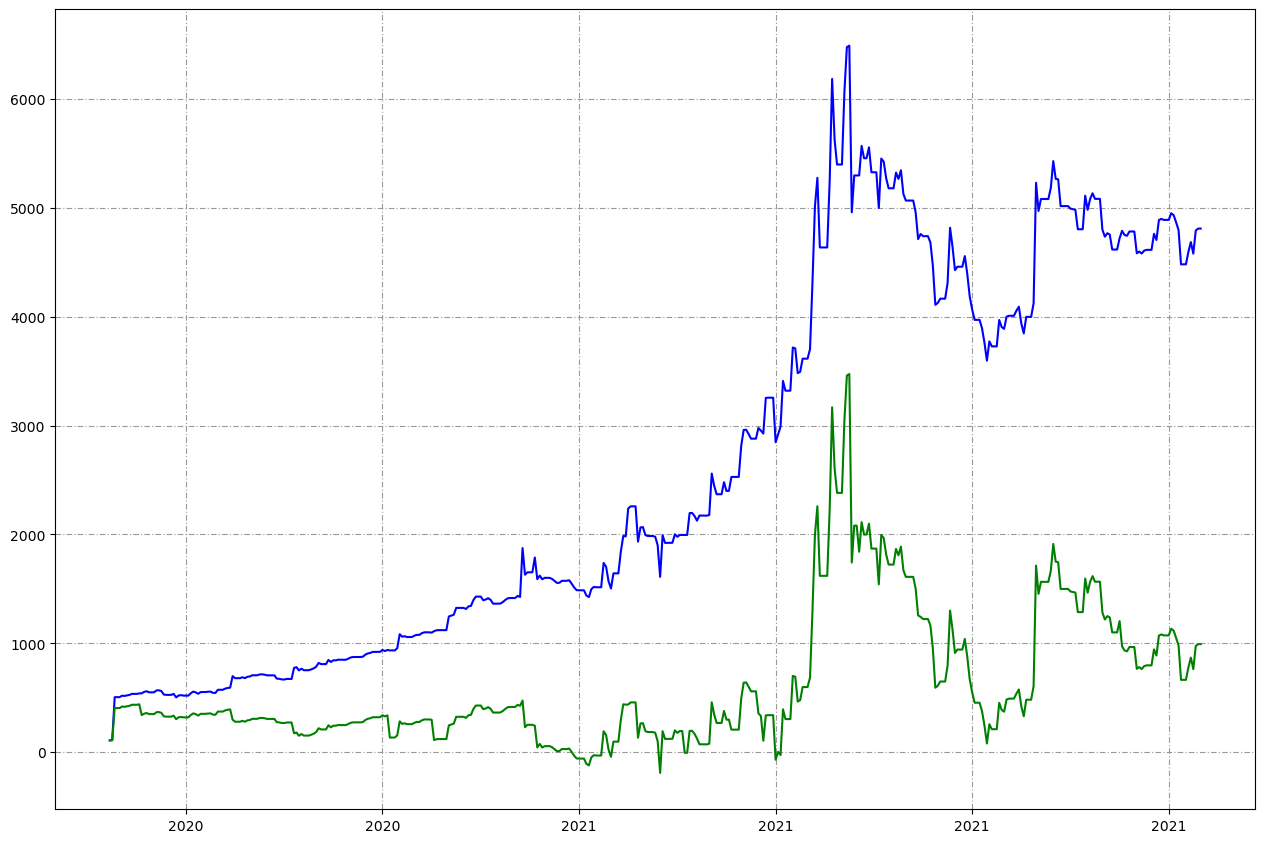

In [124]:
    # Defines area taken up by the plot
    fig = plt.figure(figsize=(12,8),dpi=100)
    graph = fig.add_axes([0,0,1,1])

    # Set max ticks on the x axis
    graph.xaxis.set_major_locator(plt.MaxNLocator(8))
        
    # Add a grid, color, dashes(5pts 1 pt dashes separated by 2pt space)
    graph.grid(True, color='0.6', dashes=(5, 2, 1, 2))

    price_plot(graph, df_dailyValue, 'blue')
    price_plot(graph, df_dailyGains, 'green')

In [ ]:
df_dailyActivity.to_csv('./outputs/dailyActivity.csv', index=False)
df_dailyValue.to_csv('./outputs/dailyValue.csv', index=False)
df_closing_all.to_csv('./outputs/dailyClose.csv', index=False)
df_dailyGains.to_csv('./outputs/dailyGains.csv', index=False)